<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20221014.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis
* Iterator

In [44]:
import pandas as pd 
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time, timezone, timedelta
import os 
import re

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 

from collections import defaultdict
from functools import reduce

# Customer Analysis

In [3]:
os.listdir()

['.config',
 'sales_data_with_stores.csv',
 'sales.csv',
 '1_orders_dataset.csv',
 '1_customers_dataset.csv',
 'sales_vs_discount.csv',
 'online_retail.xlsx',
 'test.csv',
 'mock_sales_data.csv',
 'mall_customers.csv',
 'KPMG_VI_New_raw_data_update_final.csv',
 'ecommerce-data.csv',
 '1_order_payments_dataset.csv',
 'sample-sales-data.csv',
 'online_retail_II.xlsx',
 'groceries.csv',
 'scanner_data.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'sample_data']

In [17]:
df_bill = pd.read_csv('1_order_payments_dataset.csv')
df_bill = df_bill[['order_id', 'payment_type', 'payment_installments', 'payment_value']]
df_bill.head()

,order_id,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,credit_card,2,128.45


In [18]:
df_ord = pd.read_csv('1_orders_dataset.csv')
df_ord = df_ord[['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp']]
df_ord.head()

,order_id,customer_id,order_status,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 8:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39


In [19]:
df_customer = pd.read_csv('1_customers_dataset.csv')
df_customer = df_customer[['customer_id', 'customer_state', 'customer_city']]
df_customer.head()

,customer_id,customer_state,customer_city
0,06b8999e2fba1a1fbc88172c00ba8bc7,SP,franca
1,18955e83d337fd6b2def6b18a428ac77,SP,sao bernardo do campo
2,4e7b3e00288586ebd08712fdd0374a03,SP,sao paulo
3,b2b6027bc5c5109e529d4dc6358b12c3,SP,mogi das cruzes
4,4f2d8ab171c80ec8364f7c12e35b23ad,SP,campinas


In [55]:
df = pd.merge(pd.merge(df_ord, df_bill, 'left','order_id'), df_customer, 'left','customer_id')

new_ord = dict(zip(df['order_id'].unique(), range(len(df['order_id'].unique()))))
new_custom = dict(zip(df['customer_id'].unique(), range(len(df['customer_id'].unique()))))
df['order_id'] = df['order_id'].apply(lambda x : new_ord.get(x, x))
df['customer_id'] = df['customer_id'].apply(lambda x : new_custom.get(x, x))
df.columns = ['order_id', 'customer_id', 'order_status', 'timestamp', 'payment_type', 'installment', 'rev', 'state', 'city']
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].to_numpy().astype('datetime64[D]')
df['month'] = df['timestamp'].to_numpy().astype('datetime64[M]')
df['hour'] = df['timestamp'].dt.hour
new_wk = dict(zip(range(7), ['sun','mon','tue','wed','thu','fri','sat']))
df['weekday'] = df['date'].dt.weekday
df['weekday'] = df['weekday'].apply(lambda x : new_wk.get(x, x))

df.head()

,order_id,customer_id,order_status,timestamp,payment_type,installment,rev,state,city,date,month,hour,weekday
0,0,0,delivered,2017-10-02 10:56:33,credit_card,1.0,18.12,SP,sao paulo,2017-10-02,2017-10-01,10,sun
1,0,0,delivered,2017-10-02 10:56:33,voucher,1.0,2.00,SP,sao paulo,2017-10-02,2017-10-01,10,sun
2,0,0,delivered,2017-10-02 10:56:33,voucher,1.0,18.59,SP,sao paulo,2017-10-02,2017-10-01,10,sun
3,1,1,delivered,2018-07-24 20:41:37,boleto,1.0,141.46,BA,barreiras,2018-07-24,2018-07-01,20,mon
4,2,2,delivered,2018-08-08 08:38:49,credit_card,3.0,179.12,GO,vianopolis,2018-08-08,2018-08-01,8,tue


In [41]:
cnt_type = df.groupby(['date', 'state', 'payment_type'])['rev'].sum().reset_index()
cnt_type.head()

,date,state,payment_type,rev
0,2016-09-04,RR,credit_card,136.23
1,2016-09-05,RS,credit_card,75.06
2,2016-09-13,SP,credit_card,40.95
3,2016-10-02,SP,credit_card,109.34
4,2016-10-03,GO,credit_card,154.57


In [48]:
cnt_type2 = cnt_type.groupby(['date','payment_type'])['rev'].sum().reset_index()
cnt_type2 = cnt_type2.assign(ratio = cnt_type2.groupby(['date'])['rev'].apply(lambda x : round(x/sum(x)*100,2)))
cnt_type2.head()

,date,payment_type,rev,ratio
0,2016-09-04,credit_card,136.23,100.00
1,2016-09-05,credit_card,75.06,100.00
2,2016-09-13,credit_card,40.95,100.00
3,2016-10-02,credit_card,109.34,100.00
4,2016-10-03,boleto,138.28,23.23


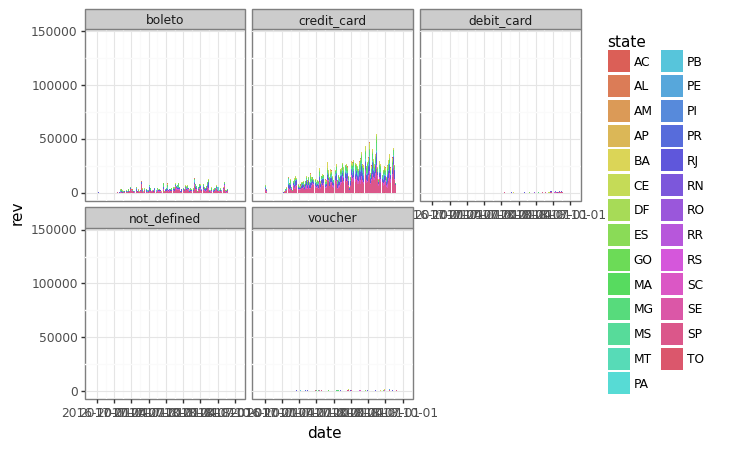

<ggplot: (8771950380417)>

In [46]:
(
    ggplot(cnt_type, aes('date', 'rev', fill = 'state')) +
    gg.geom_col() +
    gg.facet_wrap('~payment_type') +
    gg.theme_bw()
)

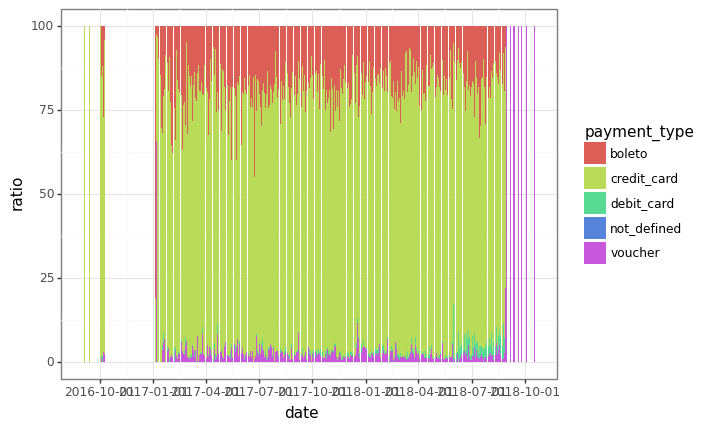

<ggplot: (8771949363637)>

In [50]:
(
    ggplot(cnt_type2, aes('date', 'ratio', fill = 'payment_type')) +
    gg.geom_col() +
    gg.theme_bw()
)

In [59]:
cnt_time = df.groupby(['weekday', 'hour'])['rev'].agg(['sum', 'count']).reset_index()
cnt_time = pd.melt(cnt_time, id_vars = ['weekday','hour'], var_name='type')
cnt_time.head()

,weekday,hour,type,value
0,fri,0,sum,44366.22
1,fri,1,sum,24262.22
2,fri,2,sum,8286.66
3,fri,3,sum,4333.35
4,fri,4,sum,5219.08


/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet.py:393: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


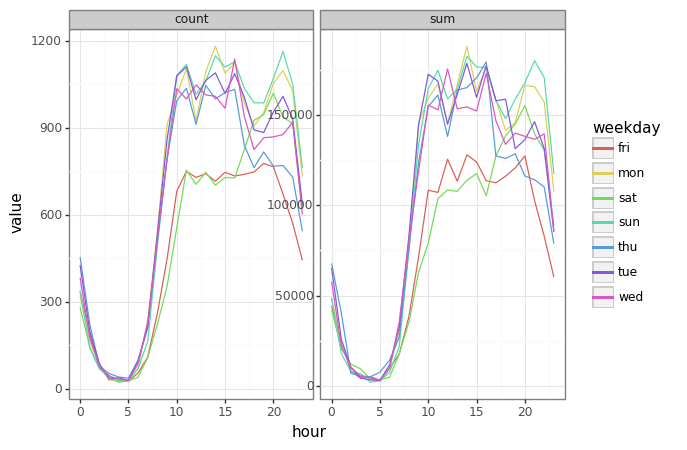

<ggplot: (8771949360865)>

In [60]:
(
    ggplot(cnt_time, aes('hour', 'value', group = 'weekday', color = 'weekday')) + 
    gg.geom_line() +
    gg.facet_wrap('~type', scales = 'free_y') +
    gg.theme_bw()
)

# Iterator

In [62]:
mat = [list('ABC'), list('DEF'), list('GHI')]
a = {letter : [r, c] for r, rows in enumerate(mat) for c, letter in enumerate(rows)}

arr = np.empty([3, 3], dtype = 'object')

for k, v in a.items() :
  arr[v[0], v[1]] = k
arr

array([['A', 'B', 'C'],
       ['D', 'E', 'F'],
       ['G', 'H', 'I']], dtype=object)

In [69]:
names = np.random.choice(['park','kim','lee'], 100, replace = True)

def get_values(names) :

  uniques, counts = np.unique(names, return_counts = True)
  unique = dict(zip(uniques, counts))

  res = list()

  for k, v in unique.items() :

    m = np.random.randint(30, 90, 1)
    s = np.random.randint(1, 30, 1)
    score = [abs(a) if a <= 100 else 100 for a in np.random.normal(m, s, v)]

    temp = pd.DataFrame({
        'name' : np.repeat(k ,v),
        'score' : score
    })

    res.append(temp)
  
  return pd.concat(res)

res = get_values(names)
res.head()

,name,score
0,kim,78.568126
1,kim,65.988747
2,kim,100.000000
3,kim,64.147337
4,kim,62.984610


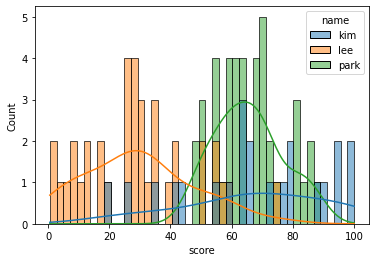

In [70]:
sns.histplot(data = res.reset_index(), x = 'score', hue = 'name', bins = 45, kde = True)